In [1]:
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
import pandas as pd
from sklearn.metrics import r2_score
%run -i '../../../../utils.py'

In [116]:
def plot_scfa_microbiome_inference(
    df_elasnet,  # elastic net dataset
    df_rf,       # random forest dataset
    group=None,  # can be 'producer', 'consumer', None
    topN=10, 
    figsize=(10,6), 
    save=False
):
    # reformat elastic net
    df_elasnet = df_elasnet.stack().reset_index()
    df_elasnet = df_elasnet[~df_elasnet.level_1.isin(['BestAlpha','BestL1Ratio','R2'])]
    df_elasnet.columns=['SCFA','Variable','Coefficient']
    df_elasnet = df_elasnet.reset_index(drop=True)

    # reformat random forest
    df_rf = df_rf.stack().reset_index()
    df_rf = df_rf[~df_rf.level_1.isin(['R2'])]
    df_rf.columns=['SCFA','Variable','Gini']
    df_rf = df_rf.reset_index(drop=True)

    # merge two tables
    df_joined = pd.merge(df_rf, df_elasnet, left_on=['SCFA','Variable'], right_on=['SCFA','Variable'], how='inner')
    df_joined.columns = ['SCFA','Taxon','RandomForest','ElasticNet']

    # select positive or negatiev elasticNet results
    if group is not None:
        if group=='producer':
            df_joined = df_joined[df_joined.ElasticNet>0]
        if group=='consumer':
            df_joined = df_joined[df_joined.ElasticNet<0]
    all_scfa = sorted(set(df_joined.SCFA))
    
    fig, ax = plt.subplots(figsize=figsize, nrows=1, ncols=len(all_scfa), constrained_layout=True)
    cbar_ax = fig.add_axes([1.00, .45, .015, .2])
    for k,scfa in enumerate(all_scfa):
        curr_df = df_joined[df_joined.SCFA==scfa]
        curr_df = curr_df.sort_values(by='RandomForest', ascending=False)
        
        # select top Random Forest important scores
        curr_df = curr_df.iloc[0:topN,:] 

        # normalize ElasticNet to -1 and 1
        curr_df.loc[curr_df.ElasticNet>0,'ElasticNet'] = curr_df.loc[curr_df.ElasticNet>0,'ElasticNet']/curr_df.loc[curr_df.ElasticNet>0,'ElasticNet'].max()
        curr_df.loc[curr_df.ElasticNet<0,'ElasticNet'] = curr_df.loc[curr_df.ElasticNet<0,'ElasticNet']/np.abs(curr_df.loc[curr_df.ElasticNet<0,'ElasticNet']).max()
        
        # plot    
        norm = matplotlib.colors.Normalize(vmin=-1, vmax=1, clip=True)
        mapper = matplotlib.cm.ScalarMappable(norm=norm, cmap='RdBu_r')
        _ = sns.barplot(y='Taxon', x='RandomForest', orient='h',
                        palette=mapper.to_rgba(curr_df['ElasticNet']), edgecolor=".2",
                        data=curr_df, ax=ax[k], dodge=False) 
        if k==0:
            ax[k].figure.colorbar(mapper, cax=cbar_ax)
            cbar_ax.set_ylabel('normalized ElasticNet coefficients', )
        ax[k].set_xlabel('RF importance score')
        ax[k].set_title(scfa, fontsize=15)
        
    # save to figure
    if save:
        plt.rcParams['svg.fonttype'] = 'none'
        if producer:
            fig.savefig("scfa_producer_no_scfa_top%d.svg"%(topN), format="svg")
        else:
            fig.savefig("scfa_consumer_no_scfa_top%d.svg"%(topN), format="svg")
    
    plt.tight_layout()

# SCFA vs microbiome

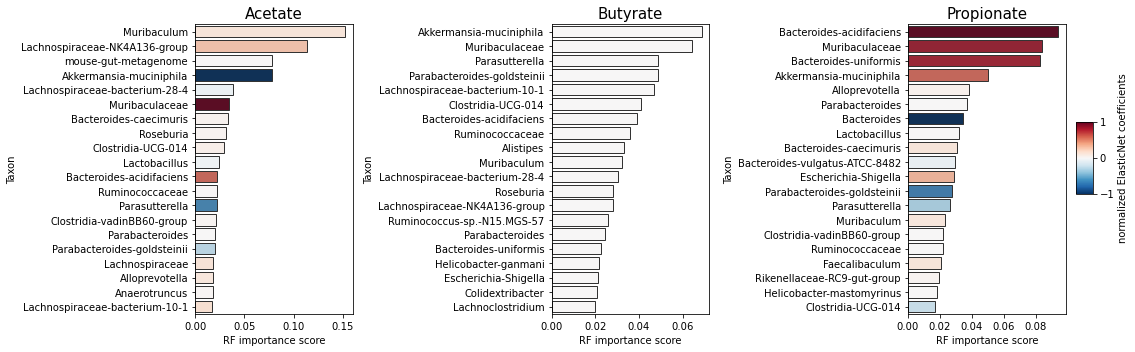

In [117]:
df_elasnet = pd.read_csv('scfa_conc_vs_microbiome/absolute_abundance/elasnet_regression_no_time.csv', index_col=0).set_index('SCFA')
df_rf = pd.read_csv('scfa_conc_vs_microbiome/absolute_abundance/rf_regression_no_time.csv', index_col=0).set_index('SCFA')
plot_scfa_microbiome_inference(df_elasnet, df_rf, topN=20, group=None, figsize=(15,5), save=False)

# dSCFA/dt vs microbiome

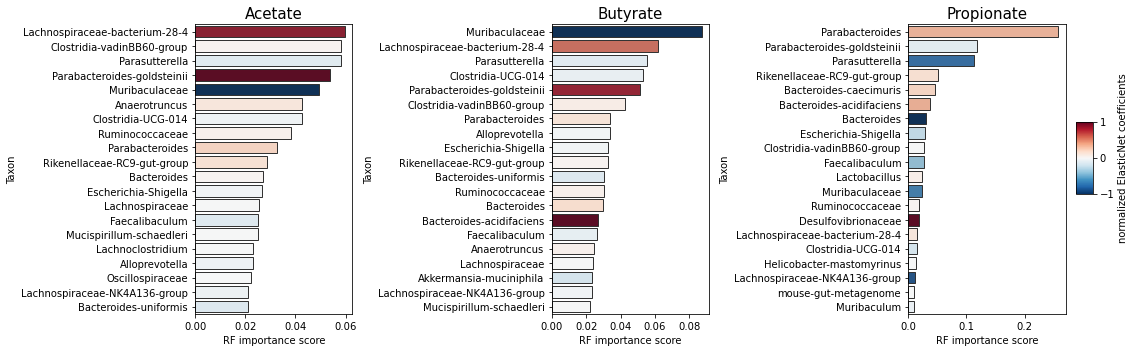

In [118]:
df_elasnet = pd.read_csv('scfa_deriv_vs_microbiome/absolute_abundance/elasnet_regression_no_scfa.csv', index_col=0).set_index('SCFA')
df_rf = pd.read_csv('scfa_deriv_vs_microbiome/absolute_abundance/rf_regression_no_scfa.csv', index_col=0).set_index('SCFA')
plot_scfa_microbiome_inference(df_elasnet, df_rf, topN=20, group=None, figsize=(15,5), save=False)

# dSCFA/dt vs dMicrobiome/dt

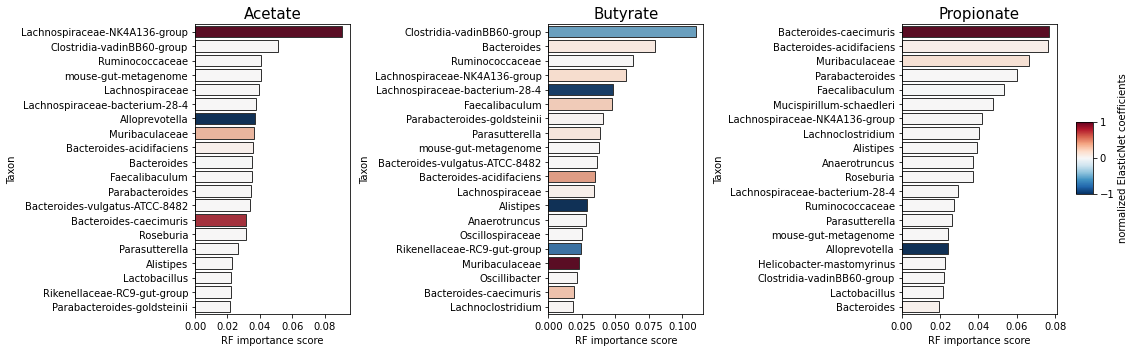

In [119]:
df_elasnet = pd.read_csv('scfa_deriv_vs_microbiome_deriv/absolute_abundance/elasnet_regression_no_scfa.csv', index_col=0).set_index('SCFA')
df_rf = pd.read_csv('scfa_deriv_vs_microbiome_deriv/absolute_abundance/rf_regression_no_scfa.csv', index_col=0).set_index('SCFA')
plot_scfa_microbiome_inference(df_elasnet, df_rf, topN=20, group=None, figsize=(15,5), save=False)

# Compare observed and predicted SCFA derivatives 

In [29]:
def predict_scfa_deriv(scfa=False):
    df_pred = None

    # get raw data
    df_meta = pd.read_excel('../../../../../our_data/meta_data.xlsx', index_col=0)
    df_meta = df_meta[df_meta.Diet=='Inulin']
    df_meta = df_meta.drop('Diet', axis=1)
    df_scfa = pd.read_excel('../../../../../our_data/SCFA.xlsx', index_col=0)
    df_bac = pd.read_excel('../../../../../our_data/16S_absolute_abundance.xlsx', index_col=0)

    # get trained model
    target_scfa=['Acetate','Butyrate','Propionate']
    if scfa:
        df_opt_paras = pd.read_csv('optimal_rf_parameters_w_scfa.csv', index_col=0)
    else:
        df_opt_paras = pd.read_csv('optimal_rf_parameters_no_scfa.csv', index_col=0)

    target_scfa_sliced, df_meta_sliced, df_bac_sliced, df_scfa_sliced, df_scfa_deriv = data_processing_scfa(
        df_meta, df_bac, df_scfa, target_scfa, topN=40, normalize_X=True, exclude_group=None, exclude_vendor=None)

    _,_,reg = train_scfa_dynamics_model(
        df_meta=df_meta, # meta data
        df_bac=df_bac,  # relative abundace or absolute abundance of gut microbiome
        df_scfa=df_scfa, # SCFA measurement
        target_scfa=target_scfa, # dependent variable(s) in the regression
        topN=40, # keep only the most abundance N taxa in the model
        normalize_X=True, # normalize maximum of bacterial abundance to 1
        exclude_group=None, # group of mice excluded from model training
        exclude_vendor=None, # group of mice excluded from model training
        model='RandomForest',# regression model
        opt_params = df_opt_paras, # optimal model parameters
        scfa=scfa # if True, add SCFA scfa, i.e., dSCFA/dt = f(microbiome, SCFA)
    )

    # predict SCFA derivative
    for scfa_ in target_scfa:
        df_pred_tmp = deepcopy(df_scfa_deriv)
        df_pred_tmp = df_pred_tmp[[x for x in df_pred_tmp.columns if x not in list(set(target_scfa)-set([scfa_]))]]
        df_pred_tmp = df_pred_tmp.rename({scfa_:'SCFA_deriv_observed'}, axis=1)
        df_pred_tmp['SCFA_mol'] = scfa_
        df_pred_tmp['SCFA_value_observed'] = df_scfa_sliced[scfa_]

        if scfa:
            X_var = np.concatenate((np.asarray(df_bac_sliced.values), np.asarray(df_scfa_sliced[scfa_]).reshape(-1,1)), 1)
        else:
            X_var = np.asarray(df_bac_sliced.values)
        df_pred_tmp['SCFA_deriv_predicted'] = reg[scfa_].predict(X_var)

        if df_pred is None:
            df_pred = df_pred_tmp
        else:
            df_pred = pd.concat([df_pred, df_pred_tmp], ignore_index=True)

    return df_pred

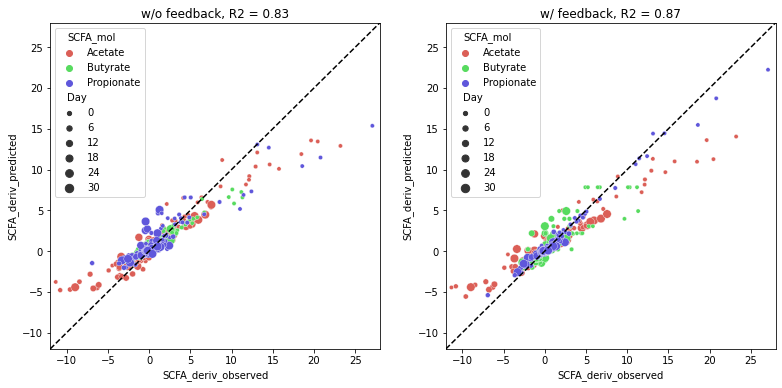

In [30]:
df_pred_no_scfa = predict_scfa_deriv(scfa=False)
df_pred_w_scfa = predict_scfa_deriv(scfa=True)

fig, ax = plt.subplots(figsize=(13,6), nrows=1, ncols=2)

# no scfa
_ = sns.scatterplot(x='SCFA_deriv_observed',y='SCFA_deriv_predicted', hue='SCFA_mol', size='Day', palette=sns.color_palette("hls", 3), data=df_pred_no_scfa, ax=ax[0])
_ = ax[0].plot([-12,28],[-12,28],'k--')
_ = ax[0].set_xlim([-12,28])
_ = ax[0].set_ylim([-12,28])
_ = ax[0].set_title('w/o scfa, R2 = %2.2f'%(r2_score(df_pred_no_scfa.SCFA_deriv_observed, df_pred_no_scfa.SCFA_deriv_predicted)))

# w/ scfa
_ = sns.scatterplot(x='SCFA_deriv_observed',y='SCFA_deriv_predicted', hue='SCFA_mol', size='Day', palette=sns.color_palette("hls", 3), data=df_pred_w_scfa, ax=ax[1])
_ = ax[1].plot([-12,28],[-12,28],'k--')
_ = ax[1].set_xlim([-12,28])
_ = ax[1].set_ylim([-12,28])
_ = ax[1].set_title('w/ scfa, R2 = %2.2f'%(r2_score(df_pred_w_scfa.SCFA_deriv_observed, df_pred_w_scfa.SCFA_deriv_predicted)))

# Plot importance score in hierachical cluster (no scfa)

In [162]:
# read elastic net
df_elasnet = pd.read_csv('elasnet_regression_no_scfa.csv', index_col=0).set_index('SCFA')
df_elasnet = df_elasnet.iloc[:,3:]

# read pearson correlation
df_pearsonr = pd.read_csv('correlation_no_scfa.csv', index_col=0)
df_pearsonr = df_pearsonr[['SCFA','Taxa','PearsonR']]
df_pearsonr = pd.pivot_table(columns='Taxa', values='PearsonR', index='SCFA', data=df_pearsonr)
df_pearsonr = df_pearsonr[df_elasnet.columns]

# random forest
df_rf = pd.read_csv('rf_regression_no_scfa.csv', index_col=0).set_index('SCFA')
df_rf = df_rf.iloc[:,1:]
df_rf = df_rf[df_elasnet.columns]

# signed important score
df_rf = np.sign(df_elasnet)*df_rf 
#df_rf = np.sign(df_pearsonr)*df_rf

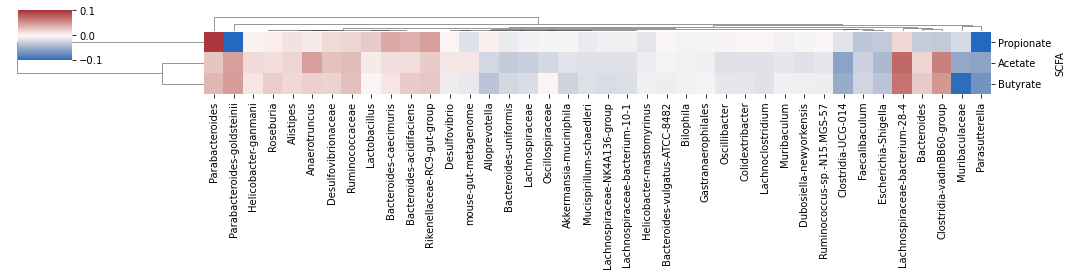

In [178]:
ax = sns.clustermap(df_rf,
                   method='average',
                   cmap="vlag",
                   figsize=(15,3.8),
                   vmin=-0.1,
                   vmax=0.1
                  )
plt.rcParams['svg.fonttype'] = 'none'
ax.savefig("rf_signed_importance_score.svg", format="svg")

In [140]:
# plot the correlation between SCFA production rate vs. relative/abosolute abundance
target_scfa_sliced, df_meta_sliced, df_bac_sliced, df_scfa_sliced, df_scfa_deriv = data_processing_scfa(
    df_meta = df_meta, 
    df_bac = df_bac, 
    df_scfa = df_scfa, 
    target_scfa=['Acetate','Butyrate','Propionate'],
    topN=40,
    normalize_X=False,
    exclude_group=None,
    exclude_vendor=None,
    use_deriv=True)
df_joined = pd.merge(df_meta_sliced, df_scfa_sliced, left_index=True, right_index=True, how='inner')
df_joined = pd.merge(df_joined, df_bac_sliced, left_index=True, right_index=True, how='inner')
df_joined.head()

MiceID   Vendor  Day RandomizedGroup    Acetate  Butyrate  \
SampleID                                                              
sample141    BI1  Beijing    0               A   5.233899  1.109582   
sample142    BI2  Beijing    0               B  13.459823  1.546647   
sample143    BI3  Beijing    0               D  18.075378  1.682656   
sample144    BI4  Beijing    0               E  12.580368  1.477688   
sample145    BI5  Beijing    0               C   8.065127  1.835172   

           Propionate  Muribaculaceae  Akkermansia-muciniphila  \
SampleID                                                         
sample141    1.930933    2.558057e+07             2.803564e+06   
sample142    3.621771    1.221770e+07             1.240226e+05   
sample143    2.859916    2.765050e+07             3.721486e+05   
sample144    3.148773    2.018975e+07             5.967865e+04   
sample145    3.134209    4.461250e+07             6.279657e+05   

           Bacteroides-acidifaciens  ...  Parabacteroides  \
SampleID                             ...                    
sample141              7.311172e+05  ...     1.934474e+05   
sample142              1.518836e+06  ...     9.874785e+04   
sample143              1.919005e+07  ...     7.668770e+06   
sample144              5.359602e+06  ...     5.738332e+05   
sample145              3.589337e+06  ...     4.865472e+05   

           Bacteroides-caecimuris  Lactobacillus  Anaerotruncus  \
SampleID                                                          
sample141           120904.594544   1.069650e+06   3.442225e+05   
sample142           114030.258771   6.060062e+05   1.610530e+05   
sample143           489229.069651   5.658889e+05   9.700952e+05   
sample144           172149.962751   5.967865e+04   2.947207e+06   
sample145           127950.117147   3.198753e+04   5.825097e+05   

           Ruminococcaceae      Bilophila  Desulfovibrio  Gastranaerophilales  \
SampleID                                                                        
sample141     6.415056e+05  236119.561110       0.000000         2.474988e+05   
sample142     4.320219e+05  317403.813075    4114.493873         3.996937e+04   
sample143     6.829694e+05   96173.235914   33451.560318         2.313733e+05   
sample144     1.223412e+06  218056.619485  135424.637364         4.820199e+04   
sample145     5.909275e+05  114481.683763   43772.408498         1.188589e+06   

           mouse-gut-metagenome  Helicobacter-mastomyrinus  
SampleID                                                    
sample141         207671.421217               0.000000e+00  
sample142         108152.410381               0.000000e+00  
sample143         271793.927584               1.063481e+06  
sample144              0.000000               5.187452e+05  
sample145          74076.383611               4.747623e+05  

[5 rows x 47 columns]

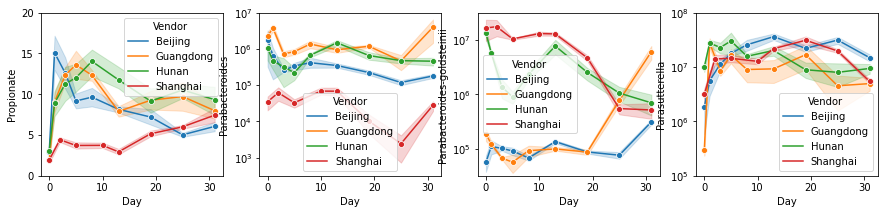

In [180]:
fig, ax = plt.subplots(figsize=(15,3), nrows=1, ncols=4)

# propionate
_ = sns.lineplot(x='Day', y='Propionate', hue='Vendor', marker='o', ci=68, data=df_joined, ax=ax[0])
_ = ax[0].set_ylim([0,20])
_ = ax[0].set_yticks([0,5,10,15,20])
_ = ax[0].minorticks_off()

# parabacteroides
_ = sns.lineplot(x='Day', y='Parabacteroides', hue='Vendor', marker='o', ci=68, data=df_joined, ax=ax[1])
_ = ax[1].set_yscale('log')
_ = ax[1].set_ylim([10**(2.5),10**(7)])
_ = ax[1].minorticks_off()

# parabacteroides
_ = sns.lineplot(x='Day', y='Parabacteroides-goldsteinii', hue='Vendor', marker='o', ci=68, data=df_joined, ax=ax[2])
_ = ax[2].set_yscale('log')
_ = ax[2].set_ylim([10**(4.5),10**(7.5)])
_ = ax[2].minorticks_off()

# parasutterella
_ = sns.lineplot(x='Day', y='Parasutterella', hue='Vendor', marker='o', ci=68, data=df_joined, ax=ax[3])
_ = ax[3].set_yscale('log')
_ = ax[3].set_ylim([10**(5),10**(8)])
_ = ax[3].minorticks_off()

plt.rcParams['svg.fonttype'] = 'none'
fig.savefig("propionate_pos_neg_associations.svg", format="svg")

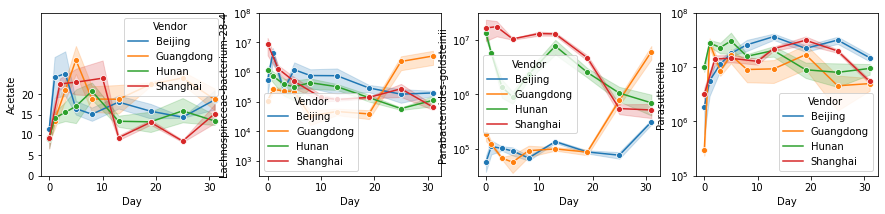

In [184]:
fig, ax = plt.subplots(figsize=(15,3), nrows=1, ncols=4)

# propionate
_ = sns.lineplot(x='Day', y='Acetate', hue='Vendor', marker='o', ci=68, data=df_joined, ax=ax[0])
_ = ax[0].set_ylim([0,40])
_ = ax[0].set_yticks([0,5,10,15,20])
_ = ax[0].minorticks_off()

# parabacteroides
_ = sns.lineplot(x='Day', y='Lachnospiraceae-bacterium-28-4', hue='Vendor', marker='o', ci=68, data=df_joined, ax=ax[1])
_ = ax[1].set_yscale('log')
_ = ax[1].set_ylim([10**(2.5),10**(8)])
_ = ax[1].minorticks_off()

# parabacteroides
_ = sns.lineplot(x='Day', y='Parabacteroides-goldsteinii', hue='Vendor', marker='o', ci=68, data=df_joined, ax=ax[2])
_ = ax[2].set_yscale('log')
_ = ax[2].set_ylim([10**(4.5),10**(7.5)])
_ = ax[2].minorticks_off()

# parasutterella
_ = sns.lineplot(x='Day', y='Parasutterella', hue='Vendor', marker='o', ci=68, data=df_joined, ax=ax[3])
_ = ax[3].set_yscale('log')
_ = ax[3].set_ylim([10**(5),10**(8)])
_ = ax[3].minorticks_off()

plt.rcParams['svg.fonttype'] = 'none'
fig.savefig("butyrate_pos_neg_associations.svg", format="svg")